In [ ]:
# IF YOU GET CUDA OUT OF MEMORY ERROR, try to load less images.

In [1]:
#@title download requirements
! pip install grad-cam --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 91.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16

In [2]:
# PATH SETUP IN YOUR GOOGLE DRIVE THAT YOU NEED TO COMPLETE !

# path to the saved weights of the vgg16 like model
weights_path = 'drive/MyDrive/'
# path to folder containing unziped STACK-MIX and STACK-GEN dataset
folder_path_dataset = 'drive/MyDrive/'

In [3]:
#@title Imports of librairies
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
# setup drive
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision
import torchvision.transforms as transforms
from PIL import Image

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, LayerCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image



import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Set the logging level of matplotlib to ERROR to ignore warnings
import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR)

import numpy as np
import math

import random

import cv2
import time
import urllib
import pickle
import itertools
from urllib.request import urlopen

from tqdm.notebook import tqdm

import matplotlib.animation as animation

from IPython.display import HTML
from base64 import b64encode

torch.manual_seed(3)
np.random.seed(3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


In [4]:
#@title utils functions and classes

# Custom dataset class.
class CustomImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.image_paths = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith(('.png', '.jpg', '.jpeg', '.JPEG'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# LOAD ONE OF THE FOLLOWING DATASETS:

In [5]:
#@title Load dataset STACK-MIX

# Define a transform to convert the image to a PyTorch tensor
transform = transforms.Compose([
    # transforms.Resize(256),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load all images from the specified folder
path_to_cutemix = folder_path_dataset + f"/cutemix"
dataset = CustomImageDataset(directory=path_to_cutemix, transform=transform)

# Create a DataLoader to batch the images
size_dataset = len([name for name in os.listdir(path_to_cutemix) if os.path.isfile(os.path.join(path_to_cutemix, name))])
dataloader = DataLoader(dataset, batch_size=int(size_dataset), shuffle=False)

# get the whole 100 images of one of our dataset.
whole_dataset_batch = next(iter(dataloader)).to(device)

In [16]:
#@title Load dataset STACK-GEN

# Define a transform to convert the image to a PyTorch tensor
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Another possible transformation that you can try.
# transform = transforms.Compose([
#     transforms.Resize(224),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])


# Load all images from the specified folder
# dataset = datasets.ImageFolder(root=folder_path_dataset, transform=transform)
path_to_gen = folder_path_dataset + f"/gen_cropped"
dataset = CustomImageDataset(directory=path_to_gen, transform=transform)

# Create a DataLoader to batch the images
size_dataset = len([name for name in os.listdir(path_to_gen) if os.path.isfile(os.path.join(path_to_gen, name))])
dataloader = DataLoader(dataset, batch_size=int(size_dataset), shuffle=False)

# get the whole 100 images of one of our dataset.
whole_dataset_batch = next(iter(dataloader)).to(device)

In [6]:
#@title Create custom model using VGG16 from torchvision.

# get vgg16 with: None ("IMAGENET1K_V1" to get the pretrained model)
model = torchvision.models.vgg16(weights = None).to(device)

# remove last max-pooling
index_to_remove = 30
new_features = list(model.features.children())[:index_to_remove] + list(model.features.children())[index_to_remove+1:]

# remove global average pooling which is not in the VGG paper of Simonyan.
custom_model = nn.Sequential(*new_features, nn.Flatten(start_dim=1),model.classifier)

# update size of first linear layer and of the last convolutional layer
custom_model[28] = nn.Conv2d(512,256,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
custom_model[-1][0] = nn.Linear(256*14*14, custom_model[-1][0].out_features)

custom_model = custom_model.to(device)


# Apply weights masking in the first dense layer to create a "dead zone" in the precedent feature maps.
with torch.no_grad():
    m = torch.ones((14,14)).to(device)
    m[-9:, :] = 0
    m = m.unsqueeze(0).repeat(256,1,1)
    m = m.unsqueeze(0).repeat(4096,1,1,1)
    m = m.reshape(4096,-1)

    custom_model[-1][0].weight *= m



In [41]:
#@title Load model pre-trained parameters.

# load the masked VGG16-like model or not.
masked = True #@param {type: 'boolean'}

if masked:
  checkpoint = torch.load(weights_path + "/params_vgg16_masked.pt")
else:
  checkpoint = torch.load(weights_path + "/params_vgg16_baseline.pt", map_location='cuda:0')

custom_model.load_state_dict(checkpoint)

<All keys matched successfully>

In [42]:
# sanity check of masking. Should be all zeros in the 9 last lines of the weights if the masked model is loaded.
custom_model[-1][0].weight[0].reshape(256,14,14)[0]

tensor([[ 0.0077,  0.0083,  0.0087,  0.0061,  0.0092,  0.0094,  0.0100,  0.0031,
          0.0071,  0.0061,  0.0078,  0.0123,  0.0105,  0.0053],
        [ 0.0056,  0.0035,  0.0114,  0.0074,  0.0050,  0.0043,  0.0038,  0.0024,
          0.0007, -0.0060, -0.0071, -0.0092,  0.0015,  0.0034],
        [ 0.0074,  0.0129,  0.0122,  0.0110,  0.0087,  0.0017,  0.0034,  0.0042,
          0.0033,  0.0032,  0.0119,  0.0118,  0.0141,  0.0144],
        [ 0.0030,  0.0065,  0.0063,  0.0065,  0.0043, -0.0072, -0.0093, -0.0028,
          0.0027, -0.0001, -0.0014, -0.0010,  0.0029,  0.0073],
        [-0.0001,  0.0155,  0.0102,  0.0041,  0.0033, -0.0028,  0.0021,  0.0040,
          0.0102,  0.0046,  0.0029,  0.0024,  0.0045,  0.0109],
        [-0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
         -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000],
        [ 0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,  0.0000, -0.0000,
         -0.0000, -0.0000, -0.0000, -0.0000, -0.0

In [43]:
#@title Compute CAM-based saliency maps for the choosed dataset and our VGG16-like model.
# the following CAM-based methods works: GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, LayerCAM


# Mapping of method names to pytorch_grad_cam CAM classes
cam_methods = {
    "GradCAM": GradCAM,
    "HiResCAM": HiResCAM,
    "ScoreCAM": ScoreCAM,
    "GradCAMPlusPlus": GradCAMPlusPlus,
    "AblationCAM": AblationCAM,
    "XGradCAM": XGradCAM,
    "EigenCAM": EigenCAM,
    "LayerCAM": LayerCAM,
}

# choose the cam method
choosed_cam_methods = "GradCAM" # @param ["GradCAM", "HiResCAM", "ScoreCAM", "GradCAMPlusPlus", "AblationCAM", "XGradCAM", "EigenCAM", "LayerCAM"]

# set model to eval mode and give the last rectified activations maps as reference for computations of the saliency maps.
custom_model.eval()
target_layers = [custom_model[-3]]

# Instantiate the chosen CAM method
if choosed_cam_methods in cam_methods:
    cam_class = cam_methods[choosed_cam_methods]
    cam = cam_class(model=custom_model, target_layers=target_layers)
else:
    raise ValueError(f"Unsupported CAM method: {choosed_cam_methods}")

# target = None means that the saliency maps will be computed for the highest scoring class of each images.
grayscale_cam = cam(input_tensor=whole_dataset_batch, targets=None)




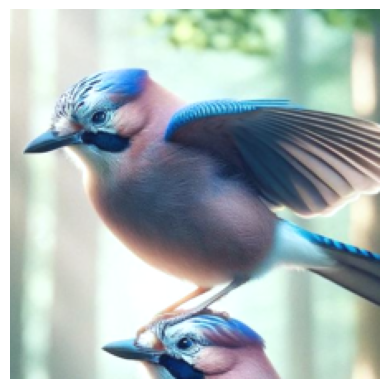

In [19]:
#@title imshow specif image from our datasets.

i = 70 #@param {type: 'integer'}
plt.imshow(np.transpose((whole_dataset_batch[i]/ (1000/225) + 0.5).squeeze().detach().cpu(), (1, 2, 0)), alpha=1)
plt.axis('off')
plt.show()

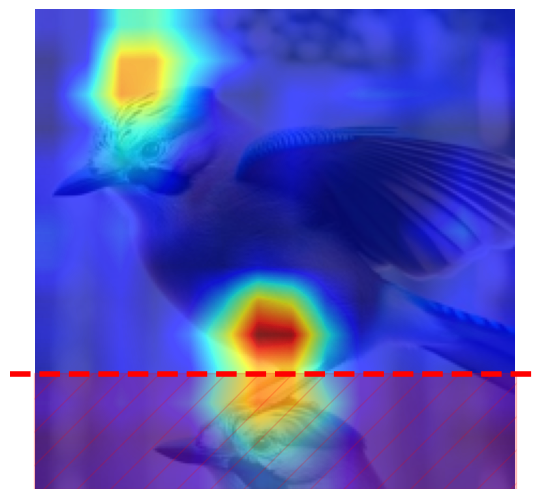

In [34]:
#@title gradcam upscaled (bilinear) for figure

i = 70 #@param {type: 'integer'}
name_to_save = f"img_{i}.png"

image = np.transpose((whole_dataset_batch[i]/ (1000/225) + 0.5).squeeze().detach().cpu(), (1, 2, 0))
gradCamMaps_tensor = grayscale_cam[i]

fig, ax = plt.subplots(1, frameon=False)

img_height, img_width = image.shape[:2]

# plot img and saliency map
ax.imshow(image, alpha = 1.)
ax.imshow(gradCamMaps_tensor, cmap = "jet", alpha = 0.7)

# plot red hatched line
xline_position = image.shape[0] / 1.32
ax.axhline(y=xline_position, color='red', linestyle='--', linewidth=4)

# Add a hatched zone to the left of the vertical line
ax.fill_betweenx(y=[xline_position-1/2, image.shape[1]-1/2], x1=-1, x2=image.shape[1], color='red', alpha=0.2, hatch='/')

# fig setup and save
ax.axis('off')

# Before saving, adjust the figure's layout
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

# Use 'bbox_inches' and 'pad_inches' to remove the white borders
fig.savefig(name_to_save, bbox_inches='tight', pad_inches=0)

plt.show()

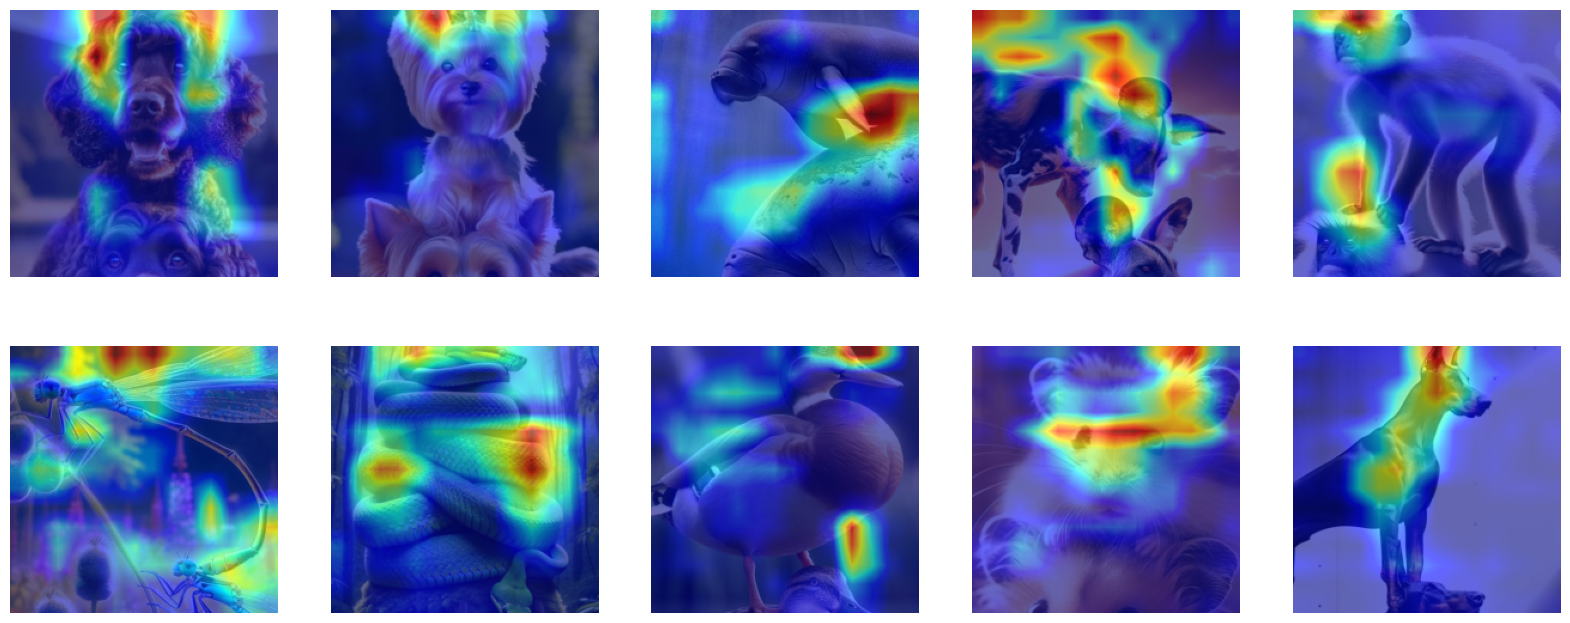

In [46]:
#@title Plot 10 random saliency maps for our dataset.
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # Creates a 2x5 grid of subplots

for i in range(10):  # Looping through the first 10 images
    ax = axes[i // 5, i % 5]  # Determines the position of the subplot

    # First image layer
    index_img = random.randint(0, 99)
    # print(index_img)
    ax.imshow(np.transpose((whole_dataset_batch[index_img] / (1000 / 225) + 0.5).squeeze().detach().cpu(), (1, 2, 0)), alpha=1)

    # Second image layer (CAM overlay)
    ax.imshow(grayscale_cam[index_img], alpha=0.6, cmap="jet")

    ax.axis('off')  # Hides the axis

plt.show()  # Displays the subplot

In [31]:
#@title Print the metric (l2-norm) of table 1 for the choosen dataset.
grayscale_cam = torch.tensor(grayscale_cam)

# l2-norm of dead zone divided by whole l2-norm of saliency map.
norms = torch.norm(grayscale_cam[:, -54:, :], dim = (1,2)) / torch.norm(grayscale_cam, dim = (1,2))

print(f"mean: {torch.mean(norms).item()}, std: {torch.std(norms).item()}")

mean: 0.5577203035354614, std: 0.21612881124019623


# METRIC AND SAVING OF SALIENCY MAPS

In [ ]:
# choice :  GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, LayerCAM

# name for pickle containing all 100 saliency maps. Put _gen at the end for STACK-GEN dataset and nothing for STACK-MIX dataset.
name = 'gradcam.pkl'

In [ ]:
# save the saliency maps
with open(name, 'wb') as f:
    pickle.dump(grayscale_cam, f)

In [ ]:
# load the saliency maps
with open(folder_path_dataset + f"/{name}", 'rb') as f:
    grayscale_cam = pickle.load(f)

In [ ]:
# command to move/copy the saved file
! cp eigencam_gen.pkl drive/MyDrive/...